<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [2]:
# Set your student number
student_number = 99106403
Name = 'Mehdi'
Last_Name = 'Abbaszadeh'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

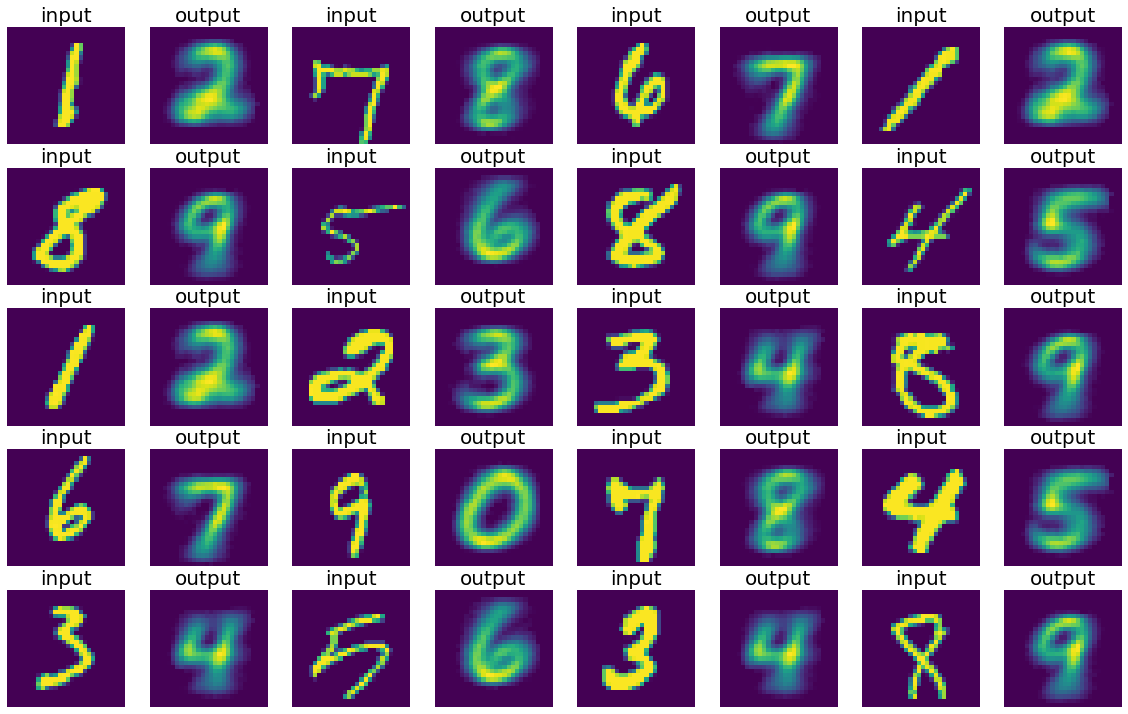

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [5]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [46]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # your code here
        self.latent_size = 8
        # Encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.linear_1 = nn.Sequential(
            nn.Linear(3 * 3 * 64, 128),
            nn.ReLU(True),
            nn.Linear(128, self.latent_size)
        )

        self.linear_2 = nn.Sequential(
            nn.Linear(self.latent_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(64, 3, 3))

        self.convtranspose = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2,
            padding=1, output_padding=1)
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # your code here
        encoded = self.cnn(x)
        flattened = self.flatten(encoded)
        latent = self.linear_1(flattened)
        reconstructed = self.linear_2(latent)
        unflattened = self.unflatten(reconstructed)
        decoded = self.convtranspose(unflattened)
        return decoded

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [7]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [13]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [14]:
# place for your custom functions for training and evaluation of the autoencoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> float:

    # your code here
    model.train()
    epoch_loss = 0.0
    criterion = nn.MSELoss()
    total = 0
    for image in dataloader:
        X = image[0].unsqueeze(1).to(device)
        Y = image[1].unsqueeze(1).to(device)
        decoded_data = model(X)

        loss = criterion(decoded_data, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = image[2].shape[0] # Compare outputs to ground truth next digit
        epoch_loss += loss.item()*batch_size
        total += batch_size
    epoch_loss /= total
    return epoch_loss


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:

    # your code here
    model.eval()
    epoch_loss = 0.0
    criterion = nn.MSELoss()
    total = 0
    with torch.no_grad():
        for image in dataloader:
            X = image[0].unsqueeze(1).to(device)
            Y = image[1].unsqueeze(1).to(device)
            decoded_data = model(X)

            loss = criterion(decoded_data, Y)  # Compare outputs to ground truth next digit
            epoch_loss += loss.item()

            batch_size = image[2].shape[0] # Compare outputs to ground truth next digit
            epoch_loss += loss.item()*batch_size
            total += batch_size
        epoch_loss /= total
    return epoch_loss



## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [47]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, weight_decay=1e-5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [48]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
num_epochs = 15

loss_data = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_autoencoder(ae, optimizer, train_dataloader)
    val_loss = eval_autoencoder(ae, val_dataloader)
    print('\n Epoch {}/{} \t train loss {} \t val loss {}\n'.format(epoch + 1, num_epochs, train_loss, val_loss))
    loss_data['train_loss'].append(train_loss)
    loss_data['val_loss'].append(val_loss)
    print("********************************")

torch.save(ae.state_dict(), "./trained_model")


 Epoch 1/15 	 train loss 0.1038084325052443 	 val loss 0.06998293333553843

********************************

 Epoch 2/15 	 train loss 0.06732033681774896 	 val loss 0.0647054703613477

********************************

 Epoch 3/15 	 train loss 0.06161485311530885 	 val loss 0.059451603994571736

********************************

 Epoch 4/15 	 train loss 0.05803187342626708 	 val loss 0.05723654550367168

********************************

 Epoch 5/15 	 train loss 0.05654590838248767 	 val loss 0.056310427499535895

********************************

 Epoch 6/15 	 train loss 0.0558837378734634 	 val loss 0.05602586695724832

********************************

 Epoch 7/15 	 train loss 0.055419337032806305 	 val loss 0.05557285748754761

********************************

 Epoch 8/15 	 train loss 0.05513391565235834 	 val loss 0.05535311770226274

********************************

 Epoch 9/15 	 train loss 0.054914535627005594 	 val loss 0.05523160641746862

********************************


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [49]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
model = AutoEncoder().to(device=device)
model.load_state_dict(torch.load("./trained_model"))

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

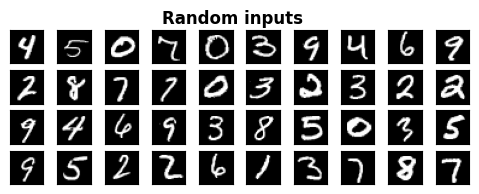

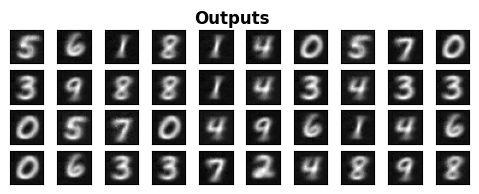

In [50]:
#### VISUALIZE YOUR MODEL ####
import matplotlib.pyplot as plt

n = 40

plt.figure(figsize=(6, 2))
t_idx = np.random.randint(0, X_test.shape[0], n)

for i in range(n):
    ax = plt.subplot(int(n/10), 10, i+1)
    img = X_test[t_idx[i]]
    model.eval()
    with torch.no_grad():
        img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Random inputs", fontweight="bold")
plt.show()

plt.figure(figsize=(6, 2))
for i in range(n):
    ax = plt.subplot(int(n/10), 10, i+1)
    img = X_test[t_idx[i]]
    model.eval()
    with torch.no_grad():
        img = torch.tensor(img.reshape((1, 1, 28, 28))).to(device)
        rec_img = model(img)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Outputs", fontweight="bold")
plt.show()